## Denoising Diffusion Probabilistic Models

In [1]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

### Set model parameters

In [2]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "MNIST"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

### Load dataset and train model

In [3]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [4]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

In [10]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
# Train model
trainer.fit(model, train_loader, val_loader)

Missing logger folder: lightning_logs/MNIST

   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/daniel/.miniconda/envs/pyro/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/daniel/.miniconda/envs/pyro/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/daniel/.miniconda/envs/pyro/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|███████████████████████| 469/469 [07:16<00:00,  1.07it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████| 469/469 [09:54<00:00,  0.79it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████| 469/469 [10:03<00:00,  0.78it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████| 469/469 [09:27<00:00,  0.83it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████████████████████| 469/469 [08:50<00:00,  0.88it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███████████████████████| 469/469 [08:23<00:00,  0.93it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████| 469/469 [08:31<00:00,  0.92it/s, v_num=0]


### Sample from model

In [12]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

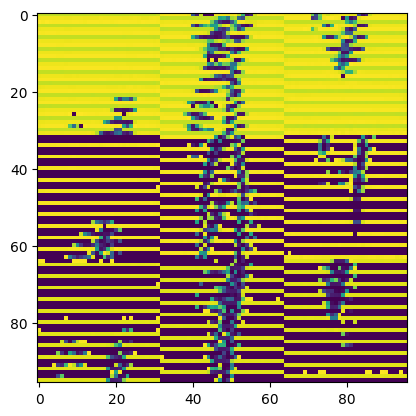

In [23]:
import matplotlib.pyplot as plt
plt.imshow(gen_samples[28, :, :, 0])

In [14]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples),
    fps=5,
)

TypeError: Cannot handle this data type: (1, 1, 1), |u1